# Environment Setup

In [5]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git
!pip install scikit-learn
!pip install openpyxl

# Loading preprocessed data

In [ ]:
import pandas as pd
from sklearn import preprocessing
import joblib

# Load data
data = pd.read_excel("..\TrainData.xlsx")

# Inspection
print("Vorm van de data:", data.shape)

# Split in features and labels
X = data.drop(columns="label")
y = data["label"]

# Scale features
def scale_features(X):
    """Scales features using StandardScaler."""
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

X_scaled = scale_features(X)

# Select features
mask = joblib.load("mask_selected_features.pkl")

X_selected = X.loc[:,mask]

# Inspection
print("X:", X_selected.shape)


Vorm van de data: (139, 494)
Vorm van de X: (139, 493)
X: (139, 19)


# 1. Randomized Search

# Define ranges of values to test for each hyperparameter

In [77]:
import numpy as np
from pprint import pprint

# Define the hyperparameter ranges for RandomForestClassifier

# 1. Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start=5, stop=50, num=20)]

# 2. Number of features to consider at every split
max_features = np.linspace(0.1, 1.0, num=10)
max_features = np.round(max_features, 1).tolist()   # Round each number to one decimal place

# 3. Maximum number of levels in a tree
max_depth = [1, 2, 3, 4, 5, 7, 9, 11]    

# 4. Minimum number of samples required to split a node
min_samples_split = [4, 5, 7, 9, 11, 13, 15, 20]

# 5. Minimum number of samples required at each leaf node
min_samples_leaf = [ 4, 5, 7, 9, 11, 13, 15]

# Create the random grid of hyperparameters
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

# Print the random grid for inspection
pprint(random_grid)


{'max_depth': [1, 2, 3, 4, 5, 7, 9, 11],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'min_samples_leaf': [4, 5, 7, 9, 11, 13, 15],
 'min_samples_split': [4, 5, 7, 9, 11, 13, 15, 20],
 'n_estimators': [5,
                  7,
                  9,
                  12,
                  14,
                  16,
                  19,
                  21,
                  23,
                  26,
                  28,
                  31,
                  33,
                  35,
                  38,
                  40,
                  42,
                  45,
                  47,
                  50]}


# Execute randomized search

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Create the base RandomForestRegressor model to tune
rf = RandomForestClassifier(bootstrap=True, criterion='gini')

# Use the random grid (defined previously) to search for the best hyperparameters.
# We perform a random search over 5000 different combinations, using 5-fold cross-validation.
# Verbose=2 displays progress details, random_state ensures reproducibility,
# and n_jobs=-1 utilizes all available CPU cores.
rf_random = RandomizedSearchCV(
    estimator=rf,                # The base model
    param_distributions=random_grid,  # The grid of hyperparameters to sample from
    n_iter=1000,                  # Number of parameter settings that are sampled
    cv=5,                        # 5-fold cross-validation
    verbose=2,                   # Verbosity level for logging progress
    random_state=42,             # For reproducibility ------> moet dit erbij???
    n_jobs=-1,                    # Use all available cores for parallel processing
    scoring='roc_auc'            # ROC AUC as scoring method
)

# Fit the random search model on the training data
rf_random.fit(X_selected, y)


# save the results of the RandomizedSearchCV
joblib.dump(rf_random, "rf_random_search.pkl")


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


['rf_random_search.pkl']

# Print results

In [82]:
# Print the best hyperparameters found during the search
print("Best Hyperparameters found: ", rf_random.best_params_)

# Print the best score achieved during the random search
print("Best score: ", rf_random.best_score_)

# Optionally, print the top 10 results based on the mean test score
random_results_df = pd.DataFrame(rf_random.cv_results_)
top_results = random_results_df[['param_n_estimators','param_max_features','param_max_depth','param_min_samples_split','param_min_samples_leaf', 'mean_test_score']]

print("\nTop 20 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).head(10))

print("\nWorst 20 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).tail(10))

Best Hyperparameters found:  {'n_estimators': 35, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.4, 'max_depth': 11}
Best score:  0.8839874411302983

Top 20 results:
     param_n_estimators  param_max_features  param_max_depth  \
214                  35                 0.4               11   
898                  26                 0.3                5   
847                  50                 0.3               11   
940                  50                 0.2               11   
954                  26                 0.4               11   
724                  47                 0.1                9   
210                  26                 0.3                9   
970                  28                 0.2                7   
707                  19                 0.2                7   
9                    19                 0.9                3   

     param_min_samples_split  param_min_samples_leaf  mean_test_score  
214                        4           

In [83]:
random_search = pd.DataFrame(rf_random.cv_results_)[
    ['mean_test_score', 'std_test_score', 'params']
].sort_values(by='mean_test_score', ascending=False)

# Save the DataFrame to a CSV file
results_df.to_csv("random_search_results.csv", index=False)

# Extract only the relevant columns
clean_results = results_df[[
    'mean_test_score',
    'std_test_score',
    'rank_test_score',
    'param_n_estimators',
    'param_max_features',
    'param_max_depth',
    'param_min_samples_split',
    'param_min_samples_leaf'
]]

# Sort by the best score (higher is better for ROC AUC)
clean_results_sorted = clean_results.sort_values(by='mean_test_score', ascending=False)

# Show the top 10 best configurations
top_20 = clean_results_sorted.head(20)

# Save the simplified top 10 table
top_20.to_csv("top10_random_search_results.csv", index=False)

# Also print it if you want a quick look
print(top_20)

      mean_test_score  std_test_score  rank_test_score  param_n_estimators  \
4129         0.900000        0.064261                1                  38   
5254         0.898901        0.064781                2                  38   
3763         0.898587        0.062166                3                  57   
4889         0.898509        0.069251                4                  60   
4888         0.898352        0.072650                5                  57   
4128         0.897881        0.062788                6                  36   
4174         0.897017        0.068978                7                  38   
4131         0.896703        0.065233                8                  42   
3762         0.896625        0.069039                9                  55   
5255         0.896272        0.070788               10                  40   
5299         0.895918        0.068344               11                  38   
4130         0.895840        0.063000               12          

# Plot results

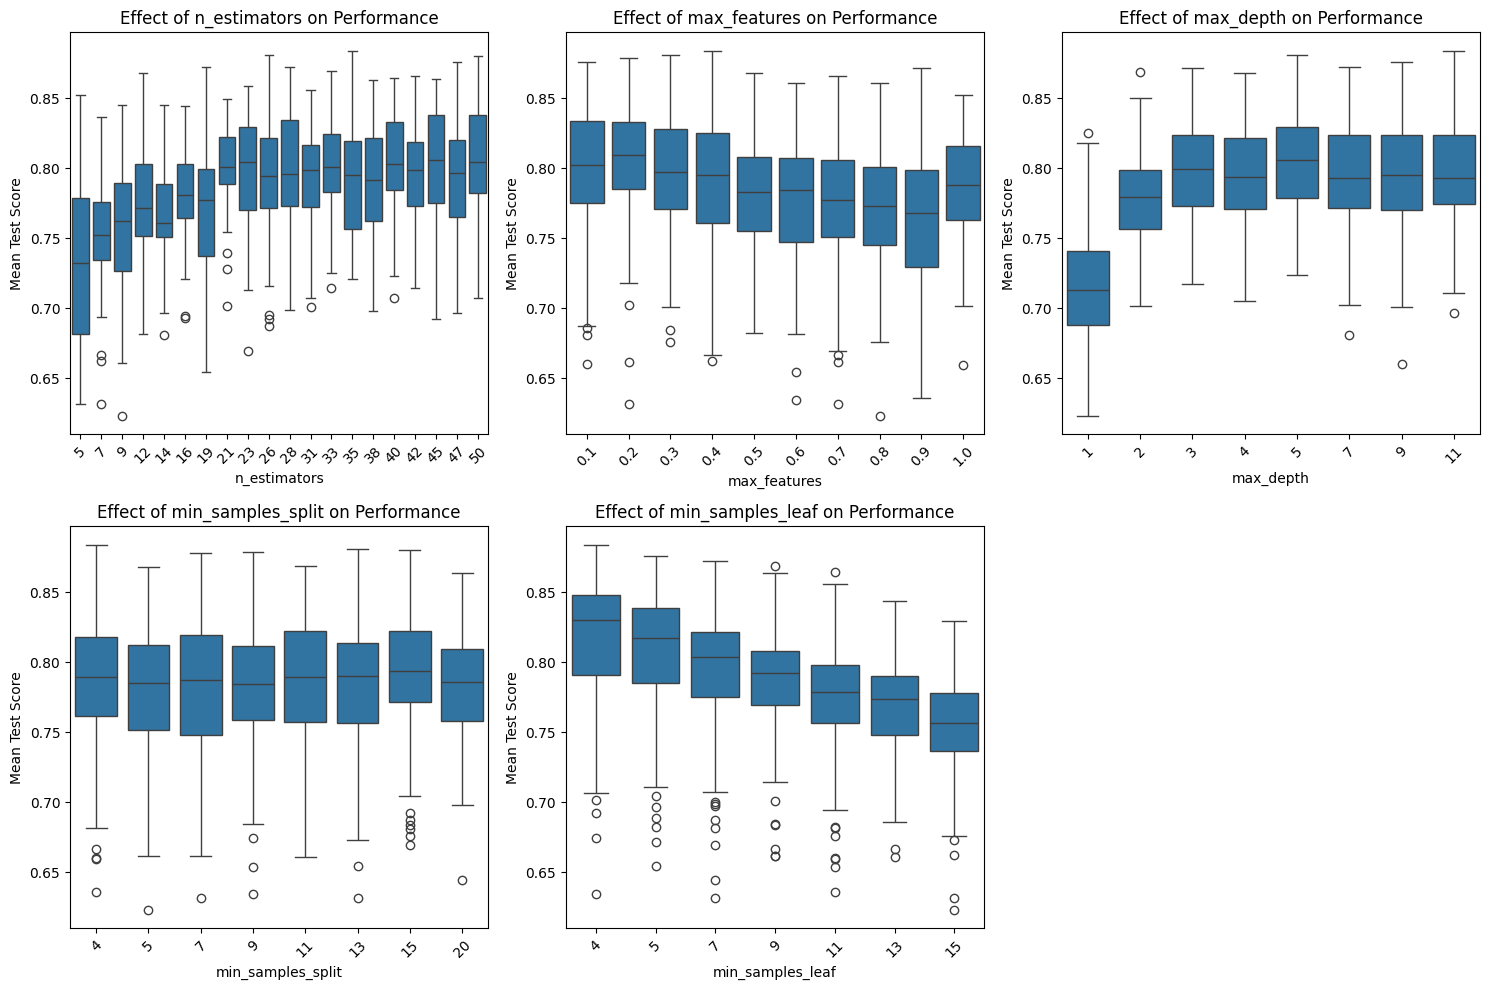

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
214       0.177758      0.062122         0.020607        0.012271   
898       0.084889      0.005316         0.009616        0.000475   
847       0.166651      0.008348         0.015357        0.001959   
940       0.152020      0.003444         0.012319        0.000543   
954       0.084520      0.003223         0.009427        0.000466   
724       0.129232      0.006593         0.011787        0.001050   
210       0.088894      0.008259         0.009866        0.001336   
970       0.099593      0.015557         0.011114        0.003009   
707       0.057656      0.003246         0.008110        0.000538   
9         0.088545      0.004499         0.011385        0.001017   
215       0.151071      0.041309         0.013942        0.001671   
287       0.110719      0.017904         0.012690        0.003108   
16        0.227078      0.062803         0.015891        0.003253   
182       0.150323      0.086468  

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to DataFrame
random_search_results = pd.DataFrame(rf_random.cv_results_)
random_search_results = random_search_results.sort_values(by="mean_test_score", ascending=False)

# List of hyperparameters to visualize
params = ["param_n_estimators", "param_max_features", "param_max_depth", "param_min_samples_split", "param_min_samples_leaf"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot each hyperparameter against mean test score
for i, param in enumerate(params):
    sns.boxplot(x=random_search_results[param], y=random_search_results["mean_test_score"], ax=axes[i])
    axes[i].set_xlabel(param.replace("param_", ""))
    axes[i].set_ylabel("Mean Test Score")
    axes[i].set_title(f"Effect of {param.replace('param_', '')} on Performance")
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplot if params < 6
if len(params) < len(axes):
    axes[-1].axis('off')

# Save the plot as an image file
plt.savefig('randomized_search_results2.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

print(random_search_results.sort_values(by='mean_test_score', ascending=False).head(20))


# 2. Grid Search

In [87]:
# Model selection
# Importeren van de benodigde libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Instellen van de hyperparameter grid voor GridSearchCV
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=20, stop=35, num=8)],  # Aantal bomen
    'max_features': [0.1, 0.2, 0.3, 0.4], 
    'max_depth': [3, 4, 5],  # Diepte van de bomen
    'min_samples_split': [3, 4, 5, 6, 7],  # Minimale samples om een interne split te maken
    'min_samples_leaf': [5,6,7,8,9],  # Minimale samples in een bladknoop
}

# Print the random grid for inspection
pprint(param_grid)

{'max_depth': [3, 4, 5],
 'max_features': [0.1, 0.2, 0.3, 0.4],
 'min_samples_leaf': [5, 6, 7, 8, 9],
 'min_samples_split': [3, 4, 5, 6, 7],
 'n_estimators': [20, 22, 24, 26, 28, 30, 32, 35]}


In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib

# Maak een RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV instellen om de beste parameters te vinden
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')

# save the results of the GridSearchCV
joblib.dump(grid_search, "rf_grid_search.pkl")

# Trainen van het model met GridSearchCV
grid_search.fit(X_selected, y)



Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
                         'max_features': [0.1, 0.2, 0.3, 0.4],
                         'min_samples_leaf': [5, 6, 7, 8, 9],
                         'min_samples_split': [3, 4, 5, 6, 7],
                         'n_estimators': [20, 22, 24, 26, 28, 30, 32, 35]},
             scoring='roc_auc', verbose=2)

In [90]:
# Toon de beste hyperparameters
print(f"Beste hyperparameters: {grid_search.best_params_}")

# Optionally, print the top 10 results based on the mean test score
results_df = pd.DataFrame(grid_search.cv_results_)
top_results = results_df[['param_n_estimators','param_max_features','param_max_depth','param_min_samples_split','param_min_samples_leaf', 'mean_test_score']]
print("\nTop 10 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).head(10))

print("\nWorst 10 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).tail(10))

Beste hyperparameters: {'max_depth': 5, 'max_features': 0.4, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 22}

Top 10 results:
      param_n_estimators  param_max_features  param_max_depth  \
2273                  22                 0.4                5   
2249                  22                 0.4                5   
2257                  22                 0.4                5   
2241                  22                 0.4                5   
2265                  22                 0.4                5   
2266                  24                 0.4                5   
2242                  24                 0.4                5   
2258                  24                 0.4                5   
2250                  24                 0.4                5   
2274                  24                 0.4                5   

      param_min_samples_split  param_min_samples_leaf  mean_test_score  
2273                        7                       6         0.86

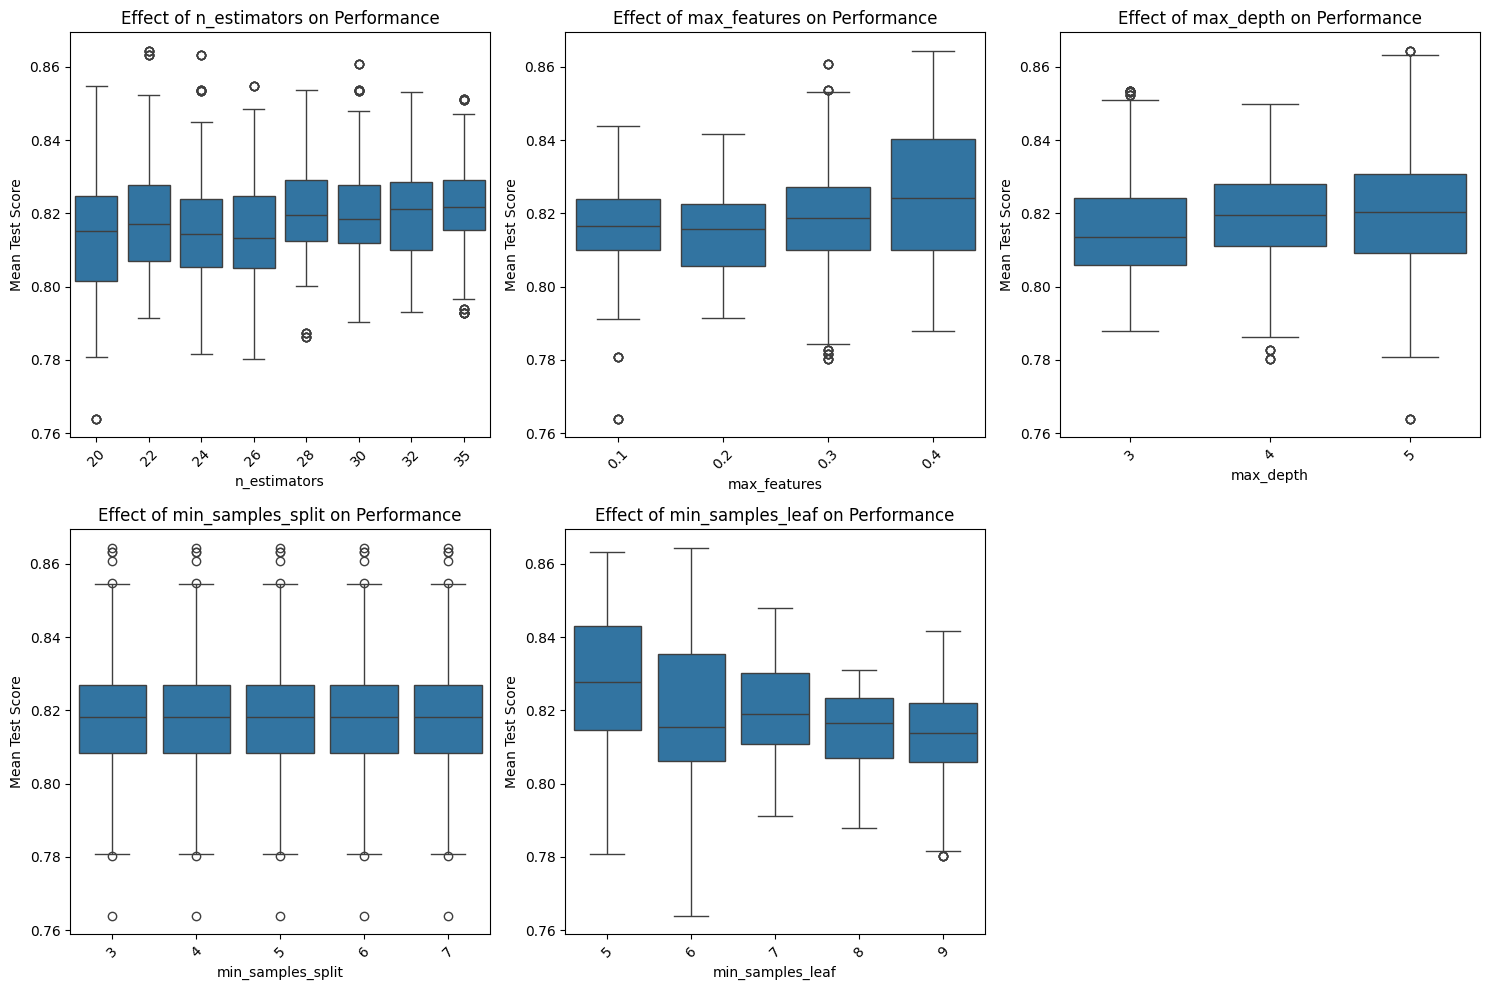

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert GridSearchCV results to DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values(by="mean_test_score", ascending=False)

# Define hyperparameters to visualize
params = ["param_n_estimators", "param_max_features", "param_max_depth",'param_min_samples_split',
           "param_min_samples_leaf"]

# Create subplots for each hyperparameter
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust grid size
axes = axes.flatten()  # Flatten for easy iteration

for i, param in enumerate(params):
    sns.boxplot(x=cv_results[param], y=cv_results["mean_test_score"], ax=axes[i])
    axes[i].set_xlabel(param.replace("param_", ""))
    axes[i].set_ylabel("Mean Test Score")
    axes[i].set_title(f"Effect of {param.replace('param_', '')} on Performance")
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels for readability

# Hide empty subplot if parameters < 6
if len(params) < len(axes):
    axes[-1].axis('off')

# Save the plot as an image file
plt.savefig('grid_search_results.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()



In [92]:
best_model = grid_search.best_estimator_
print("Best Model:", best_model)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_roc_auc = grid_search.best_score_
print(f"Best Cross-Validation ROC AUC: {best_roc_auc:.4f}")

Best Model: RandomForestClassifier(max_depth=5, max_features=0.4, min_samples_leaf=6,
                       min_samples_split=3, n_estimators=22, random_state=42)
Best Hyperparameters: {'max_depth': 5, 'max_features': 0.4, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 22}
Best Cross-Validation ROC AUC: 0.8644


In [62]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_selected, y, cv=5, scoring='roc_auc')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.3f}")
print(f"Standard deviation of cross-validation scores: {cv_scores.std():.3f}")

Cross-validation scores: [0.98979592 0.79591837 0.87244898 0.91326531 0.92857143]
Mean cross-validation score: 0.900
Standard deviation of cross-validation scores: 0.064


# Test on testdata

In [ ]:
import pandas as pd
import joblib

# Load data
data_test = pd.read_excel("..\TestData.xlsx")

# Inspection
print("Vorm van de data:", data_test.shape)

# Split in features and labels
X_test = data_test.drop(columns="label")
y_test = data_test["label"]

# Scale features
X_test_scaled = scale_features(X)

# Select features
mask = joblib.load("mask_selected_features.pkl")

X_test_selected = X_test.loc[:,mask]

# Inspection
print("X:", X_test_selected.shape)



Vorm van de data: (47, 494)
X: (47, 19)


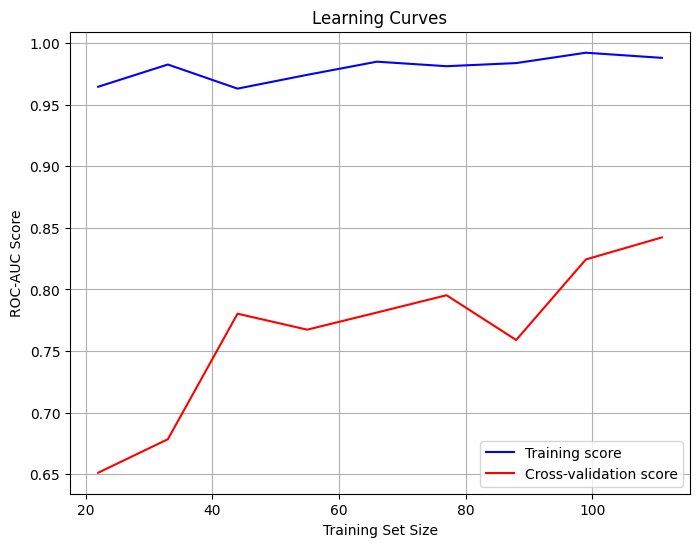

In [93]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

new_model = RandomForestClassifier(max_depth=5, max_features=0.4, min_samples_leaf=6,
                       min_samples_split=3, n_estimators=22)

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    new_model, X_selected, y, cv=5, scoring='roc_auc', n_jobs=-1, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)

# Calculate the mean and standard deviation for train and test scores
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red')
plt.xlabel('Training Set Size')
plt.ylabel('ROC-AUC Score')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()


In [60]:

# Print the column names (features) of each dataset
print("Columns in X_selected:")
print(X_selected.columns)

print("\nColumns in X_test_selected:")
print(X_test_selected.columns)


Columns in X_selected:
Index(['PREDICT_original_sf_cvar_avg_2.5D',
       'PREDICT_original_sf_solidity_std_2.5D',
       'PREDICT_original_logf_median_sigma1',
       'PREDICT_original_logf_kurtosis_sigma1',
       'PREDICT_original_logf_peak_sigma1',
       'PREDICT_original_logf_entropy_sigma1',
       'PREDICT_original_logf_peak_sigma10',
       'PREDICT_original_tf_LBP_entropy_R3_P12',
       'PREDICT_original_tf_LBP_median_R8_P24',
       'PREDICT_original_tf_LBP_quartile_range_R8_P24',
       'PREDICT_original_tf_LBP_mean_R15_P36',
       'PREDICT_original_tf_GLCM_homogeneityd3.0A2.36',
       'PREDICT_original_tf_Gabor_kurtosis_F0.05_A0.79',
       'PREDICT_original_tf_Gabor_mean_F0.05_A1.57',
       'PREDICT_original_tf_Gabor_peak_F0.05_A2.36',
       'PREDICT_original_tf_Gabor_skewness_F0.2_A0.0',
       'PREDICT_original_tf_Gabor_min_F0.2_A2.36',
       'PREDICT_original_tf_Gabor_skewness_F0.5_A0.0',
       'PREDICT_original_vf_Frangi_edge_entropy_SR(1.0, 10.0)_SS2.0'],
    


Evaluation on TestData:
Accuracy: 0.702
ROC-AUC: 0.812
F1-Score: 0.741


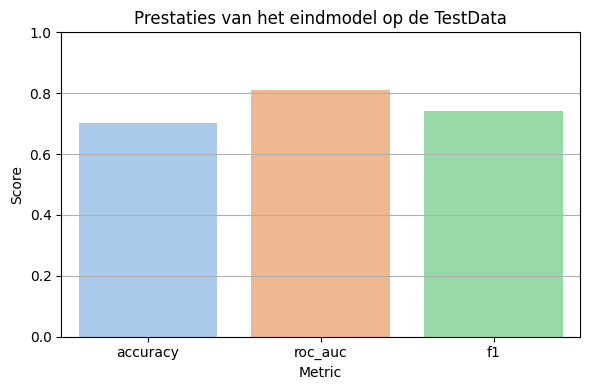

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Evaluate best model on TestData
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)

print("\nEvaluation on TestData:")
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {metrics.roc_auc_score(y_test, y_pred_proba[:, 1]):.3f}")
print(f"F1-Score: {metrics.f1_score(y_test, y_pred):.3f}")

# 🔍 Barplot voor prestaties op TestData
test_scores = {
    "accuracy": metrics.accuracy_score(y_test, y_pred),
    "roc_auc": metrics.roc_auc_score(y_test, y_pred_proba[:, 1]),
    "f1": metrics.f1_score(y_test, y_pred)
}

# Maak een DataFrame van de test_scores dictionary
df_scores = pd.DataFrame(list(test_scores.items()), columns=["Metric", "Score"])

plt.figure(figsize=(6, 4))
sns.barplot(x="Metric", y="Score", data=df_scores, hue="Metric", dodge=False, palette="pastel")
plt.legend([], [], frameon=False)  # Zet de legende uit
plt.ylim(0, 1)
plt.title("Prestaties van het eindmodel op de TestData")
plt.ylabel("Score")
plt.grid(True, axis="y")
plt.tight_layout()

# Save the plot as an image file
plt.savefig('test_scores.png', dpi=300, bbox_inches='tight')

plt.show()


# Create more testsets?

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load FullDataset
file_path = "FullDataset.xlsx"
df = pd.read_excel(file_path)

# Split data into features (X) and target (y)
X = df.drop(columns=["label"])  # assuming "label" is the target column
y = df["label"]

# Split data into training and testing sets (5 test sets)
test_size = 0.2  # adjust this value to change the proportion of test data
  # adjust this value to change the random seed

test_sets = []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    test_set = pd.concat([X_test, y_test], axis=1)
    test_sets.append(test_set)

# Save each test set to a separate Excel file
for i, test_set in enumerate(test_sets):
    file_path = f"TestSet_{i+1}.xlsx"
    test_set.to_excel(file_path,index=False)